In [ ]:


# --- Webcam capture helper for Colab ---
from IPython.display import display, Javascript
from google.colab.output import eval_js
import cv2
import numpy as np
import base64



ANOTHER TEST

In [ ]:
!pip install opencv-python mediapipe numpy


INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


# Fcial Detection working greatly

new approach

In [ ]:
import cv2
import os

video_path = "/content/Himanshu_New_Dataset.mp4"
output_dir = "dataset/raw_frames"
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_filename = os.path.join(output_dir, f"frame_{frame_count:05d}.jpg")
    cv2.imwrite(frame_filename, frame)
    frame_count += 1

cap.release()
print(f"Extracted {frame_count} frames to {output_dir}")


Extracted 1153 frames to dataset/raw_frames


In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

mp_face_mesh = mp.solutions.face_mesh


In [ ]:
def eye_aspect_ratio(landmarks, left_indices, right_indices):
    # EAR for one eye
    def single_eye(eye_indices):
        p1, p2, p3, p4, p5, p6 = [landmarks[i] for i in eye_indices]
        A = np.linalg.norm(p2 - p6)
        B = np.linalg.norm(p3 - p5)
        C = np.linalg.norm(p1 - p4)
        return (A + B) / (2.0 * C)

    leftEAR = single_eye(left_indices)
    rightEAR = single_eye(right_indices)
    return (leftEAR + rightEAR) / 2.0

def mouth_opening_ratio(landmarks, top, bottom, left, right):
    A = np.linalg.norm(landmarks[top] - landmarks[bottom])  # vertical opening
    C = np.linalg.norm(landmarks[left] - landmarks[right])  # horizontal width
    return A / C

def nose_length_ratio(landmarks, top, bottom, left, right):
    A = np.linalg.norm(landmarks[top] - landmarks[bottom])  # vertical length
    B = np.linalg.norm(landmarks[left] - landmarks[right])  # horizontal width
    return A / B


In [ ]:
# ---------------- Preprocessing -----------------
def features_to_image(ear, mor, nlr, size=224):
    ear_img = np.ones((size, size)) * ear
    mor_img = np.ones((size, size)) * mor
    nlr_img = np.ones((size, size)) * nlr
    feature_img = np.stack([ear_img, mor_img, nlr_img], axis=-1)
    feature_img = feature_img.astype("float32")
    return feature_img


In [ ]:
import os
video_path = "/content/Himanshu_New_Dataset.mp4"
output_base = "dataset"

for split in ["train", "val", "test"]:
    for label in ["drowsy", "alert"]:
        os.makedirs(os.path.join(output_base, split, label), exist_ok=True)


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os

# ---------------- Feature Functions ----------------
def eye_aspect_ratio(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    return (A + B) / (2.0 * C)

def mouth_opening_ratio(mouth_points):
    A = np.linalg.norm(mouth_points[0] - mouth_points[1])  # top-bottom
    C = np.linalg.norm(mouth_points[2] - mouth_points[3])  # left-right
    return A / C

def nose_length_ratio(nose_points):
    A = np.linalg.norm(nose_points[0] - nose_points[1])  # vertical
    B = np.linalg.norm(nose_points[2] - nose_points[3])  # horizontal
    return A / B

# ---------------- MediaPipe Setup ----------------
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

cap = cv2.VideoCapture(video_path)
frame_count = 0

# Thresholds (tune as needed)
EAR_THRESHOLD = 0.25
MOR_THRESHOLD = 0.5
NLR_THRESHOLD = 0.9

# Landmark indices (MediaPipe FaceMesh)
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]
MOUTH_TOP, MOUTH_BOTTOM, MOUTH_LEFT, MOUTH_RIGHT = 13, 14, 61, 291
NOSE_TOP, NOSE_BOTTOM, NOSE_LEFT, NOSE_RIGHT = 168, 2, 102, 331

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    label = "alert"
    if results.multi_face_landmarks:
        h, w, _ = frame.shape
        mesh_points = np.array([[int(p.x * w), int(p.y * h)] for p in results.multi_face_landmarks[0].landmark])

        # EAR
        leftEAR = eye_aspect_ratio(mesh_points[LEFT_EYE])
        rightEAR = eye_aspect_ratio(mesh_points[RIGHT_EYE])
        ear = (leftEAR + rightEAR) / 2.0

        # MOR
        mor = mouth_opening_ratio([mesh_points[MOUTH_TOP], mesh_points[MOUTH_BOTTOM],
                                   mesh_points[MOUTH_LEFT], mesh_points[MOUTH_RIGHT]])

        # NLR
        nlr = nose_length_ratio([mesh_points[NOSE_TOP], mesh_points[NOSE_BOTTOM],
                                 mesh_points[NOSE_LEFT], mesh_points[NOSE_RIGHT]])

        # Drowsiness condition (any feature below/above threshold)
        if ear < EAR_THRESHOLD or mor > MOR_THRESHOLD or nlr < NLR_THRESHOLD:
            label = "drowsy"

    # Train/val/test split
    split = "train"
    if frame_count % 10 == 0:
        split = "val"
    elif frame_count % 20 == 0:
        split = "test"

    save_path = os.path.join(output_base, split, label, f"frame_{frame_count:05d}.jpg")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    cv2.imwrite(save_path, frame)
    frame_count += 1

cap.release()
face_mesh.close()
print(f"Processed {frame_count} frames into dataset with auto-labeling (EAR, MOR, NLR + MediaPipe)")


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Processed 1153 frames into dataset with auto-labeling (EAR, MOR, NLR + MediaPipe)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
train_dir = "/content/dataset/train"
val_dir   = "/content/dataset/val"


# Image generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
val_datagen   = ImageDataGenerator(rescale=1./255)


train_gen = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode="binary")
val_gen   = val_datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode="binary")



Found 1037 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load pretrained ResNet50
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")  # binary output
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 836ms/step - accuracy: 0.5566 - loss: 0.7635 - val_accuracy: 0.6207 - val_loss: 0.6439
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - accuracy: 0.5968 - loss: 0.6793 - val_accuracy: 0.6207 - val_loss: 0.6523
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 449ms/step - accuracy: 0.5917 - loss: 0.6700 - val_accuracy: 0.6207 - val_loss: 0.6424
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.6405 - loss: 0.6472 - val_accuracy: 0.6207 - val_loss: 0.6350
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.6404 - loss: 0.6336 - val_accuracy: 0.6207 - val_loss: 0.6299
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.6491 - loss: 0.6326 - val_accuracy: 0.7759 - val_loss: 0.6318
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.6533 - loss: 0.6432 - val_accuracy: 0.6207 - val_loss: 0.6129
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.6399 - loss: 0.6418 - val_accu

In [ ]:
test_loss, test_acc = model.evaluate(val_gen)
print(f"✅ Test Accuracy: {test_acc:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6212 - loss: 0.5997
✅ Test Accuracy: 0.62


Early Stopping

graphs and metrics


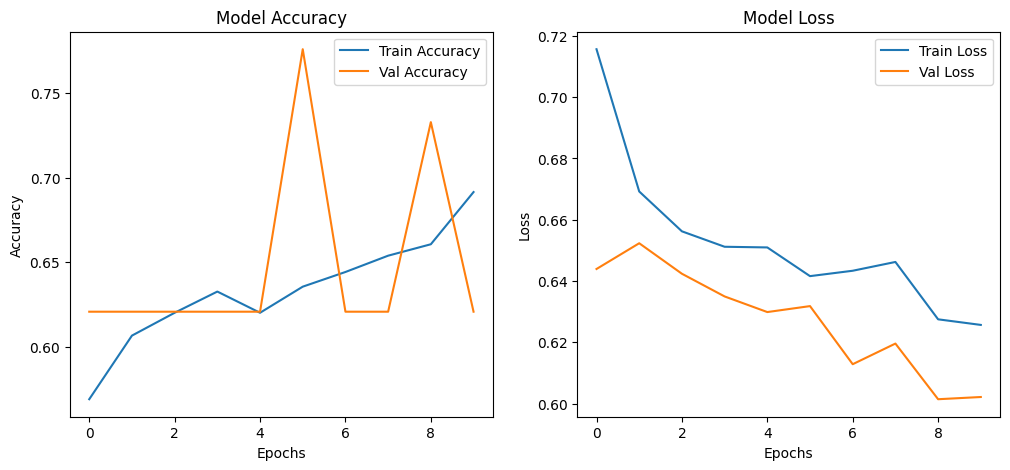

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


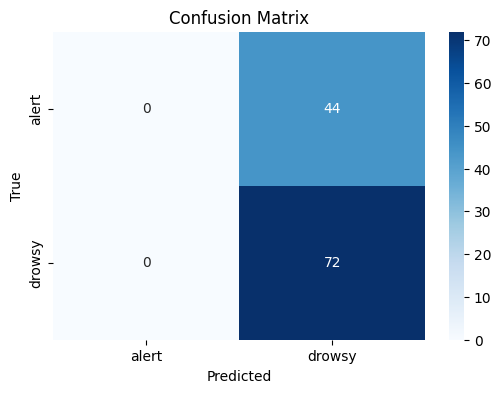

Classification Report:

              precision    recall  f1-score   support

       alert       0.00      0.00      0.00        44
      drowsy       0.62      1.00      0.77        72

    accuracy                           0.62       116
   macro avg       0.31      0.50      0.38       116
weighted avg       0.39      0.62      0.48       116



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# =============================
# 📊 Training Curves
# =============================
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

# =============================
# 🔎 Predictions & Metrics
# =============================

# Get true labels and predictions
y_true = val_gen.classes  # true labels
y_pred_probs = model.predict(val_gen)  # predicted probabilities
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()  # convert to 0/1

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_gen.class_indices.keys(),
            yticklabels=val_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (Precision, Recall, F1, Support)
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))

In [ ]:
from tensorflow import keras
model.save("Resnet50_All_Feature.h5")